In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.display_progress_bar('enable')
from tensorflow.keras import layers

In [4]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
def format_image(image,label):
    image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
    return image,label

In [6]:
num_examples = info.splits['train'].num_examples

In [7]:
num_examples

23262

In [8]:
BATCH_SIZE = 32
IMAGE_RES = 224

In [10]:
train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [12]:
feature_extractor = hub.KerasLayer(URL,
                                  input_shape=(IMAGE_RES,IMAGE_RES,3))

In [13]:
feature_extractor.trainable = False

In [14]:
model = tf.keras.Sequential([feature_extractor,
                            layers.Dense(2,activation='softmax')])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
             loss=tf.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
EPOCHS =2 
history = model.fit(train_batches,epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 79s 94ms/step - loss: 0.0599 - accuracy: 0.9786 - val_loss: 0.0351 - val_accuracy: 0.9888
Epoch 2/2
582/582 [==============================] - 51s 88ms/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 0.0382 - val_accuracy: 0.9869


In [18]:
class_names = np.array(info.features['label'].names)
print(class_names)
image_batch,label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['cat' 'dog']
['cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat'
 'dog' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog'
 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat']


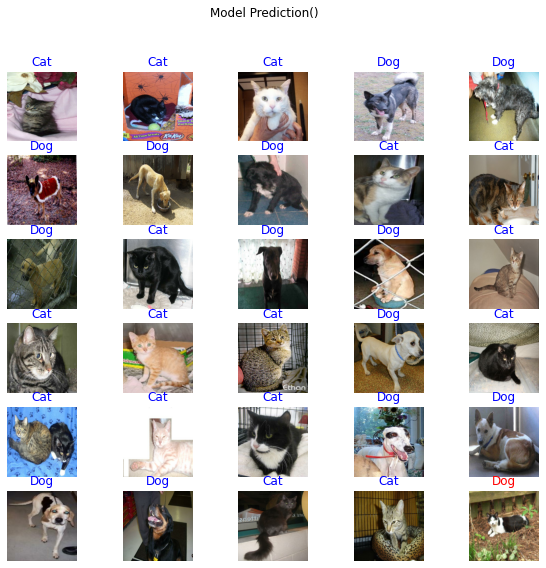

In [19]:
plt.figure(figsize=(10,9))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i])
    color = "blue" if predicted_ids[i] == label_batch[i] else "red"
    plt.title(predicted_class_names[i].title(),color=color)
    plt.axis('off')
    _= plt.suptitle("Model Prediction()")

In [20]:
# SAVE IN H5 format

In [21]:
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model.save(export_path_keras)

./1664515059.h5


In [22]:
# loading model

In [23]:
reloaded = tf.keras.models.load_model(export_path_keras,custom_objects={'KerasLayer':hub.KerasLayer})

In [24]:
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
(abs(result_batch-reloaded_result_batch)).max()

0.0

In [26]:
# want to train More -----> Keep Training

In [28]:
EPOCHS = 2
history = reloaded.fit(train_batches,epochs=EPOCHS,
                       validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 59s 89ms/step - loss: 0.0256 - accuracy: 0.9906 - val_loss: 0.0294 - val_accuracy: 0.9912
Epoch 2/2
582/582 [==============================] - 49s 84ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0316 - val_accuracy: 0.9897


In [29]:
#Export As  ------------------> Tensorflow Savemodel


In [31]:
t = time.time()
export_path_sm = './{}'.format(int(t))
print(export_path_sm)
tf.saved_model.save(model,export_path_sm)

./1664515628
INFO:tensorflow:Assets written to: ./1664515628\assets


INFO:tensorflow:Assets written to: ./1664515628\assets


In [32]:
# Loading Save_model

In [33]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [34]:
reloaded_sm_result_batch = reloaded_sm(image_batch,training=False).numpy()

In [36]:
(abs(result_batch-reloaded_sm_result_batch)).max()

0.0

In [37]:
# Loading SaveModel as kersa

In [44]:
model = tf.keras.models.clone_model(model)
t = time.time()
export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model,export_path_sm)

./1664516232
INFO:tensorflow:Assets written to: ./1664516232\assets


INFO:tensorflow:Assets written to: ./1664516232\assets


In [45]:
reloaded_sm_keras = tf.keras.models.load_model(export_path_sm,
                                              custom_objects={'KerasLayer':hub.KerasLayer})

ValueError: Unable to create a Keras model from this SavedModel. This SavedModel was created with `tf.saved_model.save`, and lacks the Keras metadata.Please save your Keras model by calling `model.save`or `tf.keras.models.save_model`.